<a href="https://colab.research.google.com/github/Gkdas2k1/My_Personal_Projects/blob/main/cyberbullying_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install pytesseract
!apt install tesseract-ocr -y
!pip install torchvision scikit-learn joblib gdown
!pip install opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [11]:
# 📦 Import libraries
import os
import io
import cv2
import numpy as np
import pandas as pd
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [12]:
def download_datasets():
    if not os.path.exists('images_dataset'):
        !git clone https://github.com/saiteja007-mv/Cyberbully-Detection-in-Texts-Images-and-Audios.git
        !mv Cyberbully-Detection-in-Texts-Images-and-Audios/images_dataset .

download_datasets()

In [13]:
# ------------------------
# 🧠 Multi-Modal Detector
# ------------------------
class MultiModalDetector:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Text components
        self.vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
        self.text_model = LogisticRegression(max_iter=1000, solver='sag', verbose=1)

        # Image components
        self.image_model = models.resnet50(pretrained=False)
        self.image_model.fc = torch.nn.Linear(2048, 2)
        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load existing models with explicit device handling
        if os.path.exists('logreg_text_model.pkl'):
            self.text_model = joblib.load('logreg_text_model.pkl')
            self.vectorizer = joblib.load('tfidf_vectorizer.pkl')

        if os.path.exists('image_model.pth'):
            # Load model to CPU first then move to current device
            self.image_model.load_state_dict(torch.load('image_model.pth', map_location='cpu'))
            self.image_model = self.image_model.to(self.device).eval()

    # 🛠️ Text model training
    def train_text_model(self, csv_path):
        print("Loading data...")
        df = pd.read_csv(csv_path)
        df['label'] = df['cyberbullying_type'].apply(lambda x: 0 if x == 'not_cyberbullying' else 1)

        # Text preprocessing
        df['clean_text'] = df['tweet_text'].str.lower() \
            .str.replace(r'[^\w\s]', '', regex=True) \
            .str.replace(r'\d+', '', regex=True) \
            .str.strip()

        # Vectorize
        print("Vectorizing features...")
        X = self.vectorizer.fit_transform(df['clean_text'])
        y = df['label']

        # Train
        print("Training logistic regression model...")
        self.text_model.fit(X, y)

        # Save models
        joblib.dump(self.text_model, 'logreg_text_model.pkl')
        joblib.dump(self.vectorizer, 'tfidf_vectorizer.pkl')

    # 🎯 Image model training
    def train_image_model(self, data_dir, epochs=5, batch_size=32):
        # Ensure model is on correct device before training
        self.image_model = self.image_model.to(self.device)

        dataset = ImageFolder(root=data_dir, transform=self.image_transform)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.image_model.parameters(), lr=0.001)

        for epoch in range(epochs):
            with tqdm(dataloader, unit="batch") as tepoch:
                for images, labels in tepoch:
                    tepoch.set_description(f"Epoch {epoch+1}/{epochs}")
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = self.image_model(images)
                    loss = criterion(outputs, labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    tepoch.set_postfix(loss=loss.item())

        torch.save(self.image_model.state_dict(), 'image_model.pth')

    # 🔍 Prediction methods
    def predict_text(self, text):
        if not text.strip():
            return 0.0
        vec = self.vectorizer.transform([text])
        return self.text_model.predict_proba(vec)[0, 1]

    def predict_image(self, pil_image):
        # Explicit device handling for input and model
        image = self.image_transform(pil_image).unsqueeze(0).to(self.device)
        self.image_model.to(self.device)  # Ensure model is on correct device
        with torch.no_grad():
            outputs = self.image_model(image)
            probs = torch.nn.functional.softmax(outputs, dim=1)
        return probs[0, 1].item()

    def predict_combined(self, text, image):
        text_prob = self.predict_text(text)
        image_prob = self.predict_image(image)
        combined_prob = (text_prob * 0.6) + (image_prob * 0.4)
        return '⚠️ Cyberbullying Detected' if combined_prob > 0.5 else '✅ Safe Content'

In [14]:
# 🖥️ Image preprocessing
def preprocess_for_ocr(pil_image):
    image = np.array(pil_image.convert('RGB'))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return Image.fromarray(thresh)

In [16]:
# 📎 Detection execution
def detect_cyberbullying(detector,external_text = None):
    from google.colab import files
    uploaded = files.upload()

    for filename in uploaded:
        pil_image = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")

        # Text analysis
        ocr_image = preprocess_for_ocr(pil_image)
        extracted_text = pytesseract.image_to_string(ocr_image).strip()

        # Combine OCR text with external text (if provided)
        combined_text = f"{extracted_text} {external_text}" if external_text else extracted_text

        # Prediction
        result = detector.predict_combined(combined_text, pil_image)

        # Display results
        print(f"\n🔍 Analysis for {filename}:")
        print(f"📝 Extracted Text:\n{extracted_text}")
        print(f"📝 External Text:\n {external_text}")
        print(f"📝 Combined Text:\n{combined_text}")
        print(f"📊 Prediction:\n{result}")
        print(f"🔎 Final Result: {result}")
        display(pil_image)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading data...
Vectorizing features...
Training logistic regression model...
convergence after 20 epochs took 0 seconds


Epoch 5/5: 100%|██████████| 75/75 [00:24<00:00,  3.03batch/s, loss=0.4]


Saving download.jpg to download.jpg

🔍 Analysis for download.jpg:
📝 Extracted Text:

📝 External Text:
 None
📝 Combined Text:

📊 Prediction:
✅ Safe Content
🔎 Final Result: ✅ Safe Content


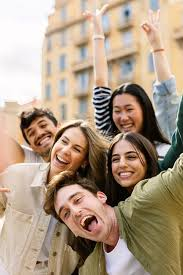

In [18]:
if __name__ == "__main__":
    # Initialize detector
    detector = MultiModalDetector()

    # Train models
    detector.train_text_model('cyberbullying_tweets.csv')
    detector.train_image_model('images_dataset',epochs=5)

    # Run detection
    detect_cyberbullying(detector)